### Oleksiy Anokhin | Hanwen Serena Xu | Surendiran Rangaraj(August 5, 2020)

### Starbucks App Customer Rewards Program

### MSCA 31008 | Data Mining Principles | Professor U. Pamuksuz | Team Project

This file only contains the steps and code for Data Preprocessing and Combibing Multiple Datasets.

**Context**
<br>

The goal of this project was to predict customer responsiveness to specific marketing efforts. One of the main challenges of this project was to generate a single dataset derived from 3 datasets and to prepare the data for later analysis. The data files used for this project were sourced from Kaggle:
https://www.kaggle.com/blacktile/starbucks-app-customer-reward-program-data

## Table of Contents
**1) Data Preprocessing and Combining Multiple Datasets** 
- Data Cleaning
- Feature Engineering
- Merging/Concatenating/Joining
<br>

**2) Exploratory Data Analysis (EDA)**
- Summary Statistics
- Univariate Analysis
- Bivariate Analysis
<br>

**3) Data Preparation**
- Feature Correlation
- Dummy Coding
- Training, Validation and Test Split
- Scaling Data
<br>

**4) Model Building & Validation**
- Baseline Accuracy
- Random Forest Classifier
- Neural Network Classifier
- XGBoost Classifier
- Model Comparison
<br>

**5) Saving the Model**
- Saving the Best Performing Model for Future Deployment
<br>

**6) Conclusion**
- Business Implications and Recommendations

# 1) Combining Multple Datasets

In [ ]:
# load imports
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MultiLabelBinarizer # awesome for multiple values in one cell
import csv # write csv file of the complete dataset
from datetime import date 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler # for scaling
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score # model validation
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import keras
from keras.wrappers.scikit_learn import KerasClassifier
from keras import optimizers
from sklearn.externals import joblib
import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [ ]:
# Read in files
portfolio = pd.read_json('portfolio.json', orient='records', lines=True)
profile = pd.read_json('profile.json', orient='records', lines=True)
transcript = pd.read_json('transcript.json', orient='records', lines=True)

## Examine Dataset One: Portfolio

**Columns dictionary**:
1. id (string) - offer id
2. offer_type (string) - type of offer i.e. BOGO(Buy One Get One), discount, informational.
3. difficulty (int) - minimum required spend to complete an offer.
4. reward (int) - reward given for completing an offer.
5. duration (int) - time for offer to be open, in days.
6. channels (list of strings)

In [ ]:
portfolio.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [ ]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


As specified in the source description, the **ID** column listed in the portfolio file refers to **Offer ID**.
<br>

Let's change the name of this column to **Offer ID**.

In [ ]:
portfolio.rename(columns = {'id':'offer_id'},inplace=True)

Check for unique values in Offer Type and Channels. This is not necessarily important here because we only have 10 rows but will be useful for bigger datasets. Let's do it anyway.

In [ ]:
print("offer_type unique values: {}".format(portfolio['offer_type'].unique()))

offer_type unique values: ['bogo' 'informational' 'discount']


In [ ]:
# check for unique values/ combinations in list "channels"
unique_list = [] 
# loop through list      
for channels in portfolio.channels: 
    if channels not in unique_list: 
        unique_list.append(channels) 
        
# print unique combinations
for channels in unique_list: 
    print (channels) 

['email', 'mobile', 'social']
['web', 'email', 'mobile', 'social']
['web', 'email', 'mobile']
['web', 'email']


One can see that both features are not in an appropriate format for machine learning models. Thus, let's create new columns out of these 2 columns with the aim to separate the entries in each row. Subsequently, we will drop the old columns.

In [ ]:
# separate the entires in the "channels" column and dummy code them
mlb = MultiLabelBinarizer()
channels_array = mlb.fit_transform(portfolio["channels"])
channels_df = pd.DataFrame(data=channels_array, columns=mlb.classes_)
# merge channels_df with portfolio again
portfolio = pd.concat([portfolio, channels_df], axis=1)

# also dummy code "offer_type" 
portfolio = pd.concat([portfolio, pd.get_dummies(portfolio['offer_type'])], axis=1)

# examine if it worked porperly
portfolio.head(10)

,reward,channels,difficulty,duration,offer_type,offer_id,email,mobile,social,web,bogo,discount,informational
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,1,0,0
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1,0,0,1
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1,1,0,0
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1,0,1,0
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1,0,1,0
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1,0,1,0
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837,1,1,1,0,0,0,1
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,1,0,0
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,0,1,0,1,0


In [ ]:
# quick comment: all missing data in "channels" were assigned a "0"

# drop "channels" and "offer_type" columns since they are now redundant
portfolio.drop("channels", axis=1, inplace=True)
portfolio.drop("offer_type", axis=1, inplace=True)

portfolio.head() # we keep offer_id to be able to merge the data sets later

,reward,difficulty,duration,offer_id,email,mobile,social,web,bogo,discount,informational
0,10,10,7,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,1,0,0
1,10,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0
2,0,0,4,3f207df678b143eea3cee63160fa8bed,1,1,0,1,0,0,1
3,5,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1,1,0,0
4,5,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1,0,1,0


As a result, the first dataset is now ready to be used for machine learning. The Offer ID column remains in its current state because it will be used to merge the datasets later on.

## Examine Dataset Two: Profile

**Columns dictionary**:
1. age (int) - age of the customer.
2. becamememberon (int) - date when customer created an app account.
3. gender (string) - gender of the customer (note some entries contain 'O' for other rather than M or F).
4. id (string) - customer id.
5. income (float) - customer's income.

In [ ]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [ ]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


As written on Kaggle, **ID** refers to **Customer ID** and therefore we will rename the column.

In [ ]:
profile.rename(columns = {'id':'customer_id'},inplace=True)

One can observe that the profile dataset contains missing values for **Gender** and **Income**. In fact, they show the exact same total number of missing values. We have 2175 missing entries for **Ggender**. We can see in the output of .info() that **Income** has the same number of missing values. I suspect that for these two columns there are missing data in the same rows. Let's check and then drop these rows.

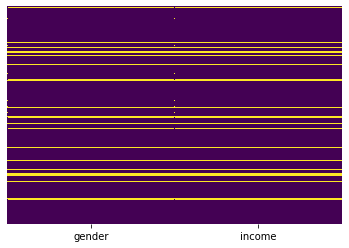

In [ ]:
# for a closer comparison
gender_income = profile[["gender", "income"]].copy()
sns.heatmap(gender_income.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [ ]:
profile.dropna(inplace=True)
profile.reset_index(inplace=True,drop=True) # resetting the index due to dropped values
profile.isna().sum()

gender              0
age                 0
customer_id         0
became_member_on    0
income              0
dtype: int64

No missing values left.

In [ ]:
profile["gender"].value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

Upon further examination of the **Gender** feature, one can see that 212 customers did not want to give an answer or specify their gender. Let's remove these entries because this will not yield useful insights for our analysis later on. As last step for the **Gender** feature, the column will be dummy-coded and the original column dropped.

In [ ]:
profile = profile[profile.gender != 'O']
profile['male'] = profile['gender'].map({'M':1,'F':0}) # 1 is male, 0 is female
profile[['gender','male']] # to check if it worked proprely

,gender,male
0,F,0
1,F,0
2,M,1
3,M,1
4,M,1
...,...,...
14820,F,0
14821,M,1
14822,M,1
14823,F,0


In [ ]:
# now we can drop the original column
profile.drop(columns = 'gender', inplace = True) 

The feature **Became Member On** is supposed to be in datetime format. However, this is not the case here. Moreover, in order to be able to use this feature in any machine learning model, it must be feature engineered. 

My approach:

First, convert the current column format (int) to datetime and then calculate the total number of membership days per customer. Lastly, I will drop the old column.


In [ ]:
# convert column to datetime
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format="%Y%m%d")

In [ ]:
# let's see the timeframe the customer data was collected
print(profile["became_member_on"].min(),profile["became_member_on"].max()) 

2013-07-29 00:00:00 2018-07-26 00:00:00


The customer data was collected between July 29th, 2013 and July 26th, 2018

In [ ]:
# create a function to convert the column into total number of days
def total_days_converter(start_date, end_date= profile["became_member_on"].max()):
    for date in start_date:
        days = (end_date-start_date)
        return days 

In [ ]:
# apply function to perform the conversion
profile["membership_days"] = total_days_converter(profile["became_member_on"])
profile.drop(columns="became_member_on", inplace=True)
profile["membership_days"].head()

0   376 days
1   443 days
2    91 days
3   167 days
4   257 days
Name: membership_days, dtype: timedelta64[ns]

In [ ]:
# since we are only interested in the total number of days we can extract the number of days and convert it to integer format
profile['membership_days'] = pd.to_numeric(profile['membership_days'].dt.days, downcast='integer')

In [ ]:
# glance of the df structure
profile.head()

,age,customer_id,income,male,membership_days
0,55,0610b486422d4921ae7d2bf64640c50b,112000.0,0,376
1,75,78afa995795e4d85b5d9ceeca43f5fef,100000.0,0,443
2,68,e2127556f4f64592b11af22de27a7932,70000.0,1,91
3,65,389bc3fa690240e798340f5a15918d5c,53000.0,1,167
4,58,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,1,257


The second dataset is ready to be used for merging. The **Customer ID** column remains in its current state because it will be used to merge the datasets next. However, this dataset is not yet suitable for machine learning because the 3 datetime columns need more processing which will be conducted later.

## Examine Dataset Three: Transcript

**Columns dictionary**:
1. event (str) - record description (ie transaction, offer received, offer viewed, etc.)
2. person (str) - customer id.
3. time (int) - time in hours since the start of the test. The data begins at time t=0.
4. value - (dict of strings) - either an offer id or transaction amount depending on the record.

In [ ]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [ ]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


According to the information given on Kaggle, **Person** refers to **Customer ID** so let's rename this column.

In [ ]:
transcript.rename(columns = {'person': 'customer_id'}, inplace = True)

Next, the feature **Value** will be examined.

In [ ]:
# check for unique values in "value" column
values_per_key = {}
for d in transcript.value:
    for k, v in d.items():
        values_per_key.setdefault(k, set()).add(v)
counts = {k: len(v) for k, v in values_per_key.items()}
counts

{'amount': 5103, 'offer id': 10, 'offer_id': 8, 'reward': 4}

Looks like the data for multiple columns ended up in this single column or the file didn't read in properly. In its current state the **Value** column contains information from 3 separate columns. This is based on the assumption that **Offer_ID** and **Offer ID** are the same column.

**My approach:**

- split the column into separate columns and store them into a new dataframe
- check values and then combine the two offer_id columns
- drop the old columns
- combine the two dataframes

In [ ]:
# split the columns and create new dataframe with these columns
df = transcript["value"].apply(pd.Series)

# combine "offer_id" and "offer id" into a single columns based on NaNs and drop both afterwards
df["offer_id_new"] = df['offer_id'].fillna(df["offer id"])
df.drop(columns = 'offer_id', inplace = True )
df.drop(columns = 'offer id', inplace = True )

# combine the new column with the transcript dataframe again
transcript_1 = pd.concat([transcript, df], axis=1)

# change the "offer_id_new" column label to "offer_id"
transcript_1.rename(columns = {'offer_id_new': 'offer_id'}, inplace = True)

transcript_1.head(10)

,customer_id,event,value,time,amount,reward,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,NaN,NaN,2906b810c7d4411798c6938adc9daaa5
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,NaN,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0
5,389bc3fa690240e798340f5a15918d5c,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0,NaN,NaN,f19421c1d4aa40978ebb69ca19b0e20d
6,c4863c7985cf408faee930f111475da3,offer received,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},0,NaN,NaN,2298d6c36e964ae4a3e7e9706d1fb8c2
7,2eeac8d8feae4a8cad5a6af0499a211d,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},0,NaN,NaN,3f207df678b143eea3cee63160fa8bed
8,aa4862eba776480b8bb9c68455b8c2e1,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
9,31dda685af34476cad5bc968bdb01c53,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7


Looks like it worked as intended. Next, let's drop the original **Value** column since it is now redundant.

In [ ]:
transcript_1.drop(columns = "value", inplace=True)

Taking a closer look look at **Offer ID** and **Customer ID**. 

In [ ]:
transcript_1.sort_values(['customer_id', "offer_id"]).head(10)

,customer_id,event,time,amount,reward,offer_id
247879,0009655768c64bdeb2e877511632db8f,offer received,576,NaN,NaN,2906b810c7d4411798c6938adc9daaa5
258884,0009655768c64bdeb2e877511632db8f,offer completed,576,NaN,2.0,2906b810c7d4411798c6938adc9daaa5
113605,0009655768c64bdeb2e877511632db8f,offer received,336,NaN,NaN,3f207df678b143eea3cee63160fa8bed
139992,0009655768c64bdeb2e877511632db8f,offer viewed,372,NaN,NaN,3f207df678b143eea3cee63160fa8bed
55972,0009655768c64bdeb2e877511632db8f,offer received,168,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837
77705,0009655768c64bdeb2e877511632db8f,offer viewed,192,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837
153401,0009655768c64bdeb2e877511632db8f,offer received,408,NaN,NaN,f19421c1d4aa40978ebb69ca19b0e20d
168413,0009655768c64bdeb2e877511632db8f,offer completed,414,NaN,5.0,f19421c1d4aa40978ebb69ca19b0e20d
187554,0009655768c64bdeb2e877511632db8f,offer viewed,456,NaN,NaN,f19421c1d4aa40978ebb69ca19b0e20d
204340,0009655768c64bdeb2e877511632db8f,offer received,504,NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4


In [ ]:
# Drop transcript rows whose customer_id is not in profile customer id
transcript_1 = transcript_1[transcript_1.customer_id.isin(profile.customer_id)]


Many customers received multiple offers (**Offer IDs**) multiple times and each step along the process was recorded in this dataset.
<br>

**Process:** Offer Received -> Offer Viewed -> Offer Completed
<br>
There are two major problems here.

The first problem is that an offer is completed by making a transaction. However, no transaction is recorded with related offer id. In the meanwhile, not all transactions are related to offers. **Solution**: For each customer, based on the offer completed time and transaction time, match transactions to related offers.

The second problem is that every step along the process is recorded as an observation. **Solution**: Aggregate records based on customer id and offer id. For the same customer receiving the same offer for multiple times, we use average response time and total reward and transaction amount. 

Approach: 
- Seperate **event** column to four dummy variables
- Seperate **time** column based on event
- Assign **offer_id** to offer related transactions
- Aggregate transcript_2 to form **transcript_clean** with each row showing per customer per offer


In [ ]:
transcript_1.head()

,customer_id,event,time,amount,reward,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
2,e2127556f4f64592b11af22de27a7932,offer received,0,NaN,NaN,2906b810c7d4411798c6938adc9daaa5
5,389bc3fa690240e798340f5a15918d5c,offer received,0,NaN,NaN,f19421c1d4aa40978ebb69ca19b0e20d
7,2eeac8d8feae4a8cad5a6af0499a211d,offer received,0,NaN,NaN,3f207df678b143eea3cee63160fa8bed
8,aa4862eba776480b8bb9c68455b8c2e1,offer received,0,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [ ]:
# dummy code "event" 
transcript_1 = pd.concat([transcript_1, pd.get_dummies(transcript_1['event'])], axis=1)

# examine if it worked porperly
transcript_1.head(5)

,customer_id,event,time,amount,reward,offer_id,offer completed,offer received,offer viewed,transaction
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0,0
2,e2127556f4f64592b11af22de27a7932,offer received,0,NaN,NaN,2906b810c7d4411798c6938adc9daaa5,0,1,0,0
5,389bc3fa690240e798340f5a15918d5c,offer received,0,NaN,NaN,f19421c1d4aa40978ebb69ca19b0e20d,0,1,0,0
7,2eeac8d8feae4a8cad5a6af0499a211d,offer received,0,NaN,NaN,3f207df678b143eea3cee63160fa8bed,0,1,0,0
8,aa4862eba776480b8bb9c68455b8c2e1,offer received,0,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0,0


In [ ]:
# drop "event" column since it is now redundant
transcript_1.drop("event", axis=1, inplace=True)

# rename the column
transcript_1.rename(columns = {'offer completed': 'offer_completed','offer received' : 'offer_received',
                             'offer viewed': 'offer_viewed'}, inplace = True)

# reorder the df
transcript_1 = transcript_1[["customer_id","offer_id",  'offer_received', 'offer_viewed','offer_completed', 'transaction',
                              "time", "amount", "reward"]]
#see if it works properly
transcript_1.head() 

,customer_id,offer_id,offer_received,offer_viewed,offer_completed,transaction,time,amount,reward
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0,0,0,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,2906b810c7d4411798c6938adc9daaa5,1,0,0,0,0,NaN,NaN
5,389bc3fa690240e798340f5a15918d5c,f19421c1d4aa40978ebb69ca19b0e20d,1,0,0,0,0,NaN,NaN
7,2eeac8d8feae4a8cad5a6af0499a211d,3f207df678b143eea3cee63160fa8bed,1,0,0,0,0,NaN,NaN
8,aa4862eba776480b8bb9c68455b8c2e1,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,0,0,NaN,NaN


In [ ]:
# create 4 different time columns for each event type
transcript_1["received_time"] = np.zeros(transcript_1.shape[0])
transcript_1["viewed_time"] = np.zeros(transcript_1.shape[0])
transcript_1["completed_time"] = np.zeros(transcript_1.shape[0])
transcript_1["transaction_time"] = np.zeros(transcript_1.shape[0])

# change data type to integer
transcript_1[["received_time","viewed_time","completed_time",
              "transaction_time"]]=transcript_1[["received_time","viewed_time","completed_time","transaction_time"]].astype(int)

In [ ]:
# assign time data to four columns
transcript_1.loc[transcript_1['offer_received']== 1,'received_time'] = transcript_1.loc[transcript_1['offer_received']== 1,'time']
transcript_1.loc[transcript_1['offer_viewed']== 1,'viewed_time'] = transcript_1.loc[transcript_1['offer_viewed']== 1,'time']
transcript_1.loc[transcript_1['offer_completed']== 1,'completed_time'] = transcript_1.loc[transcript_1['offer_completed']== 1,'time']
transcript_1.loc[transcript_1['transaction']== 1,'transaction_time'] = transcript_1.loc[transcript_1['transaction']== 1,'time']

#check if it works properly
transcript_1.tail(5)

,customer_id,offer_id,offer_received,offer_viewed,offer_completed,transaction,time,amount,reward,received_time,viewed_time,completed_time,transaction_time
306527,24f56b5e1849462093931b164eb803b5,fafdcd668e3743c1bb461111dcafc2a4,0,0,1,0,714,NaN,2.0,0,0,714,0
306529,b3a1272bc9904337b331bf348c3e8c17,NaN,0,0,0,1,714,1.59,NaN,0,0,0,714
306530,68213b08d99a4ae1b0dcb72aebd9aa35,NaN,0,0,0,1,714,9.53,NaN,0,0,0,714
306531,a00058cf10334a308c68e7631c529907,NaN,0,0,0,1,714,3.61,NaN,0,0,0,714
306532,76ddbd6576844afe811f1a3c0fbb5bec,NaN,0,0,0,1,714,3.53,NaN,0,0,0,714


In [ ]:
# drop 'time' column since it is now redundant
transcript_1.drop("time", axis=1, inplace=True)

# reorder the df
transcript_1 = transcript_1[['customer_id', 'offer_id', 'offer_received','received_time','offer_viewed',
                             'viewed_time','offer_completed','completed_time','transaction','transaction_time',
                             'amount', 'reward']]
transcript_1.head(5)

,customer_id,offer_id,offer_received,received_time,offer_viewed,viewed_time,offer_completed,completed_time,transaction,transaction_time,amount,reward
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0,0,0,0,0,0,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,2906b810c7d4411798c6938adc9daaa5,1,0,0,0,0,0,0,0,NaN,NaN
5,389bc3fa690240e798340f5a15918d5c,f19421c1d4aa40978ebb69ca19b0e20d,1,0,0,0,0,0,0,0,NaN,NaN
7,2eeac8d8feae4a8cad5a6af0499a211d,3f207df678b143eea3cee63160fa8bed,1,0,0,0,0,0,0,0,NaN,NaN
8,aa4862eba776480b8bb9c68455b8c2e1,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,0,0,0,0,0,NaN,NaN


In [ ]:
transcript_1.tail()

,customer_id,offer_id,offer_received,received_time,offer_viewed,viewed_time,offer_completed,completed_time,transaction,transaction_time,amount,reward
306527,24f56b5e1849462093931b164eb803b5,fafdcd668e3743c1bb461111dcafc2a4,0,0,0,0,1,714,0,0,NaN,2.0
306529,b3a1272bc9904337b331bf348c3e8c17,NaN,0,0,0,0,0,0,1,714,1.59,NaN
306530,68213b08d99a4ae1b0dcb72aebd9aa35,NaN,0,0,0,0,0,0,1,714,9.53,NaN
306531,a00058cf10334a308c68e7631c529907,NaN,0,0,0,0,0,0,1,714,3.61,NaN
306532,76ddbd6576844afe811f1a3c0fbb5bec,NaN,0,0,0,0,0,0,1,714,3.53,NaN


In [ ]:
# Select customer_id rows where the offer_compelted = 1. Select only customer_id,offer_id and completed_time. 
compl = transcript_1.loc[transcript_1['offer_completed']==1,['customer_id','offer_id','completed_time']]

# Merge the transcript Dataframe with the offer id value from customer who completed the offer basedon the completion and transaction time
transcript_2 = transcript_1.merge(compl,how='left',left_on = ['customer_id', 'transaction_time'] ,
                                  right_on=['customer_id', 'completed_time'])

# Use the offer_id value from the above Merge data only for the rows with transaction = 1
transcript_2.loc[transcript_2['transaction']== 1,'offer_id_x'] = transcript_2.loc[transcript_2['transaction']== 1,'offer_id_y']

# drop "merged columns"  as it is duplicate and rename the 
transcript_2.drop(["offer_id_y","completed_time_y"], axis=1, inplace=True)
transcript_2.rename(columns={"offer_id_x": "offer_id" , "completed_time_x" : "completed_time" }, inplace = True)

In [ ]:
#Post Update Manual Validation
transcript_2[transcript_2['customer_id'] == '9fa9ae8f57894cc9a3b8a9bbe0fc1b2f']

,customer_id,offer_id,offer_received,received_time,offer_viewed,viewed_time,offer_completed,completed_time,transaction,transaction_time,amount,reward
26,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,2906b810c7d4411798c6938adc9daaa5,1,0,0,0,0,0,0,0,NaN,NaN
10867,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,2906b810c7d4411798c6938adc9daaa5,0,0,1,0,0,0,0,0,NaN,NaN
10868,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,2906b810c7d4411798c6938adc9daaa5,0,0,0,0,0,0,1,0,34.56,NaN
10869,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,2906b810c7d4411798c6938adc9daaa5,0,0,0,0,1,0,0,0,NaN,2.0
24138,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,NaN,0,0,0,0,0,0,1,42,21.55,NaN
38812,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,NaN,0,0,0,0,0,0,1,114,32.87,NaN
45036,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,NaN,0,0,0,0,0,0,1,156,19.99,NaN
57579,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,NaN,0,0,0,0,0,0,1,168,20.97,NaN
71276,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,NaN,0,0,0,0,0,0,1,204,31.09,NaN
97402,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,2298d6c36e964ae4a3e7e9706d1fb8c2,1,336,0,0,0,0,0,0,NaN,NaN


After all records are cleaned, the next and final step is to group these records based on customer_id and offer_id, so that we have one row for each customer and offer_id. We will sum the transaction amount and offer reward, and average the time fields.

In [ ]:
# separate records based on the event to different dataframes in order to do groupby
offer_received = transcript_2.loc[transcript_2['offer_received']==1,['customer_id','offer_id','offer_received','received_time']].copy()

offer_viewed = transcript_2.loc[transcript_2['offer_viewed']==1,['customer_id','offer_id','offer_viewed','viewed_time']].copy()


offer_completed_time = transcript_2.loc[transcript_2['offer_completed']==1,
                                   ['customer_id','offer_id','offer_completed','completed_time']].copy()
offer_completed_reward = transcript_2.loc[transcript_2['offer_completed']==1,
                                   ['customer_id','offer_id','reward']].copy()

# separate transactions related to offers from those unrelated to offers
transaction = transcript_2.loc[transcript_2['transaction']==1,].fillna(0)
offer_transaction_time = transaction.loc[transaction.offer_id != 0,
                                   ['customer_id','offer_id','transaction','transaction_time']].copy()
offer_transaction_amount = transaction.loc[transaction.offer_id != 0,
                                   ['customer_id','offer_id','amount']].copy()
no_offer_transaction = transaction.loc[transaction.offer_id==0].copy()

In [ ]:
# use average time for all time column
offer_received = offer_received.groupby(['customer_id','offer_id']).mean()
offer_viewed = offer_viewed.groupby(['customer_id','offer_id']).mean()
offer_completed_time = offer_completed_time.groupby(['customer_id','offer_id']).mean()
offer_transaction_time = offer_transaction_time.groupby(['customer_id','offer_id']).mean()

# use sum amount for reward and transaction amount column
offer_completed_reward = offer_completed_reward.groupby(['customer_id','offer_id']).sum()
offer_transaction_amount = offer_transaction_amount.groupby(['customer_id','offer_id']).sum()

In [ ]:
# join all offer related records so that we have one row for each customer and offer_id
offer_related = offer_received.merge(offer_viewed,how='outer',on=['customer_id','offer_id']).merge(
    offer_completed_time,how='outer',on=['customer_id','offer_id']).merge(
        offer_completed_reward,how='outer',on=['customer_id','offer_id']).merge(
            offer_transaction_time,how='outer',on=['customer_id','offer_id']).merge(
                offer_transaction_amount,how='outer',on=['customer_id','offer_id']).reset_index()

# reorder the offer_related
offer_related = offer_related[['customer_id','offer_id','offer_received', 'received_time', 'offer_viewed', 'viewed_time',
       'offer_completed', 'completed_time', 'transaction', 'transaction_time',
       'amount', 'reward']]

In [ ]:
# concat transaction not related to offers, set multindex
transcript_clean = pd.concat((offer_related,no_offer_transaction),
                             axis=0).set_index(["customer_id", "offer_id"]).sort_values(['customer_id', "offer_id"],ascending=False)


In [ ]:
# convert customer_id and offer_id back to column
transcript_clean.reset_index(inplace=True)

Time columns alone does not provide any useful information. However, how fast customers viewed and completed the offer plays a big role here. Hence, we create columns time_viewed_received, time_completed_received and time_completed_viewed.

In [ ]:
transcript_clean['time_viewed_received'] = transcript_clean['viewed_time']-transcript_clean['received_time']
transcript_clean.loc[transcript_clean['offer_viewed']==0,'time_viewed_received'] = 0

transcript_clean['time_completed_received'] = transcript_clean['completed_time']-transcript_clean['received_time']
transcript_clean.loc[transcript_clean['offer_completed']==0,'time_completed_received'] = 0

transcript_clean['time_completed_viewed'] = transcript_clean['completed_time']-transcript_clean['viewed_time']
transcript_clean.loc[transcript_clean['offer_completed']==0,'time_completed_viewed'] = 0

In [ ]:
# reorder the dataframe
transcript_clean = transcript_clean[['customer_id', 'offer_id', 'offer_received', 'received_time','offer_viewed', 'viewed_time',
                                     'time_viewed_received','offer_completed', 'completed_time','time_completed_received',
                                     'time_completed_viewed','transaction', 'transaction_time', 'amount', 'reward']]

In [ ]:
transcript_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147508 entries, 0 to 147507
Data columns (total 15 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   customer_id              147508 non-null  object 
 1   offer_id                 147508 non-null  object 
 2   offer_received           147508 non-null  uint8  
 3   received_time            147508 non-null  float64
 4   offer_viewed             134890 non-null  float64
 5   viewed_time              134890 non-null  float64
 6   time_viewed_received     134890 non-null  float64
 7   offer_completed          120568 non-null  float64
 8   completed_time           120568 non-null  float64
 9   time_completed_received  120568 non-null  float64
 10  time_completed_viewed    116161 non-null  float64
 11  transaction              120568 non-null  float64
 12  transaction_time         120568 non-null  float64
 13  amount                   120568 non-null  float64
 14  rewa

The third and final dataset is now processed and ready for merging to create a complete dataset.

## Merging the Three Datasets into a Complete Dataset

**Step 1:** Let's start by merging the cleaned **Transcript** dataset with the **Profile** dataset on **Customer ID**.

In [ ]:
# we merge them with "how = 'outer'" to retain all rows even if there is not a match on "customer_id" 
step1 = pd.merge(transcript_clean, profile, on="customer_id", how="outer")
step1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 147508 entries, 0 to 147507
Data columns (total 19 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   customer_id              147508 non-null  object 
 1   offer_id                 147508 non-null  object 
 2   offer_received           147508 non-null  uint8  
 3   received_time            147508 non-null  float64
 4   offer_viewed             134890 non-null  float64
 5   viewed_time              134890 non-null  float64
 6   time_viewed_received     134890 non-null  float64
 7   offer_completed          120568 non-null  float64
 8   completed_time           120568 non-null  float64
 9   time_completed_received  120568 non-null  float64
 10  time_completed_viewed    116161 non-null  float64
 11  transaction              120568 non-null  float64
 12  transaction_time         120568 non-null  float64
 13  amount                   120568 non-null  float64
 14  rewa

**Step 2:** Let's merge the **Step1** dataset with the **Portfolio** dataset on **Offer ID** to create the complete dataset.

In [ ]:
step2 = pd.merge(step1, portfolio, on="offer_id", how="outer") # outer to avoid dropping NaNs or no match on Offer ID
step2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 147508 entries, 0 to 147507
Data columns (total 29 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   customer_id              147508 non-null  object 
 1   offer_id                 147508 non-null  object 
 2   offer_received           147508 non-null  uint8  
 3   received_time            147508 non-null  float64
 4   offer_viewed             134890 non-null  float64
 5   viewed_time              134890 non-null  float64
 6   time_viewed_received     134890 non-null  float64
 7   offer_completed          120568 non-null  float64
 8   completed_time           120568 non-null  float64
 9   time_completed_received  120568 non-null  float64
 10  time_completed_viewed    116161 non-null  float64
 11  transaction              120568 non-null  float64
 12  transaction_time         120568 non-null  float64
 13  amount                   120568 non-null  float64
 14  rewa

# Preparing the Complete Dataset

Finally, after merging the datasets into the complete dataset we have to do some last preprocessing steps before we can start with our analysis.
<br>

- fill NaNs with 0s
- rename **reward_x** and **reward_y** 

In [ ]:
# fill NaNs in with 0s 
step2.fillna(value=0, inplace=True)

# rename two reward column
step2.rename(columns={'reward_x':'total_reward','reward_y':'reward_each_time'},inplace=True)

Let's check for any additional missing values. If there are still find missing data we will drop them.

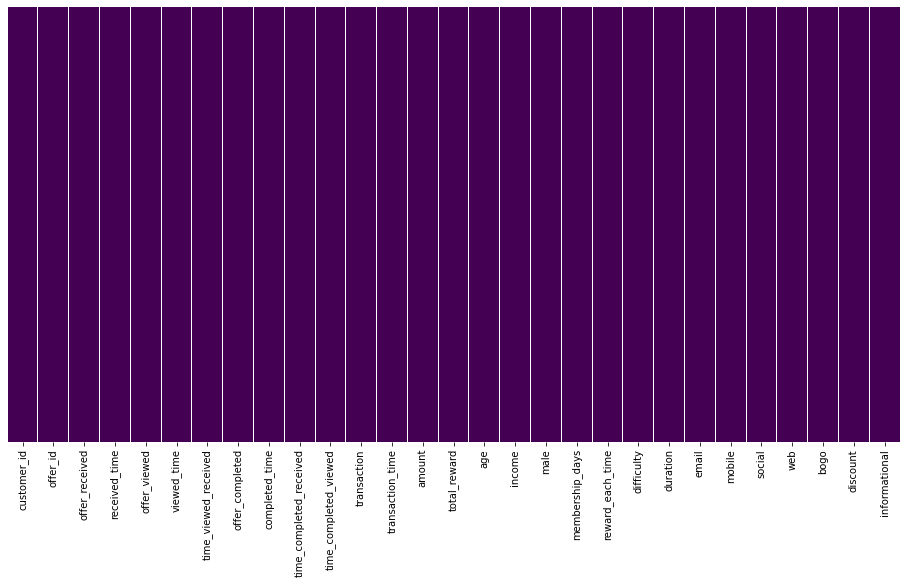

In [ ]:
plt.figure(figsize=(16,8))
sns.heatmap(step2.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [ ]:
step2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 147508 entries, 0 to 147507
Data columns (total 29 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   customer_id              147508 non-null  object 
 1   offer_id                 147508 non-null  object 
 2   offer_received           147508 non-null  uint8  
 3   received_time            147508 non-null  float64
 4   offer_viewed             147508 non-null  float64
 5   viewed_time              147508 non-null  float64
 6   time_viewed_received     147508 non-null  float64
 7   offer_completed          147508 non-null  float64
 8   completed_time           147508 non-null  float64
 9   time_completed_received  147508 non-null  float64
 10  time_completed_viewed    147508 non-null  float64
 11  transaction              147508 non-null  float64
 12  transaction_time         147508 non-null  float64
 13  amount                   147508 non-null  float64
 14  tota

No missing data left. The final dataset contains 147,508 observations and 28 columns. Let's save it as a csv file and begin with our analysis.

In [ ]:
# Write csv file of the step2 data set 
step2.to_csv("starbucks.csv")

After we have a uniform dataset, the step is to do standardlization because some algotithns like PCA and k-means are sensitive to the relative scale of the data. A large difference in the scale between income and transaction amount would negatively affect the result. **Solution:** Use StandardScaler to transform data so that its distribution will have a mean value of 0, and a standard deviation of 1. Also, standard scale dummy variable columns does not make sense, so we only do StandardScaler tranformation on numeric columns. 

In [ ]:
new_df.columns

Index(['customer_id', 'offer_id', 'offer_received', 'offer_viewed',
       'time_viewed_received', 'offer_completed', 'time_completed_received',
       'time_completed_viewed', 'transaction', 'transaction_time', 'amount',
       'total_reward', 'age', 'income', 'male', 'membership_days',
       'reward_each_time', 'difficulty', 'duration', 'email', 'mobile',
       'social', 'web', 'bogo', 'discount', 'informational'],
      dtype='object')

In [ ]:
# create a new dataframe which only contains time information on how fast customers respond.
new_df = step2.drop(['received_time','viewed_time','completed_time','transaction_time'],axis=1).copy(deep=True)

# separate numeric columns from dummy variable columns
num_new_df = new_df.loc[:,['time_viewed_received','time_completed_received','time_completed_viewed',
                          'amount','total_reward', 'age', 'income', 'membership_days',
                          'reward_each_time', 'difficulty', 'duration']].copy()

In [ ]:
from sklearn.preprocessing import StandardScaler
stscaler = StandardScaler().fit(num_new_df)
num_new_df = stscaler.transform(num_new_df)

new_df[['time_viewed_received','time_completed_received','time_completed_viewed',
                          'amount','total_reward', 'age', 'income', 'membership_days',
                          'reward_each_time', 'difficulty', 'duration']] = num_new_df

In [ ]:
# Write csv file of the standardlized data set 
new_df.to_csv("starbucks_standarlized.csv")

This dictionary is based on per customer per offer base. Each customer has one record for each offer she received. As for transactions not related to offers, each transaction has a seperate record in this dataset.

**Column Dictionary**:
1. **customer_id**
2. **offer_id** - 0 indicates that this records is a transaction record not related to offers
3. **offer_received** - 0 indicates that this record is not related to offers, 1 indicates that this customer has received a offer
4. **received_time** - time in hours since the start of the test. The data begins at time t=0
5. **offer_viewed** - 0 indicates that this offer is not viewed by this customer
6. **viewed_time** - time in hours since the start of the test. The data begins at time t=0
7. **time_viewed_received** - subtraction of received_time and viewed_time
8. **offer_completed** - 0 indicates that this offer is not completed
9. **completed_time**- time in hours since the start of the test. The data begins at time t=0
10. **time_completed_received** - subtraction of completed_time and received_time
11. **time_completed_viewed** - subtraction of completed_time and viewed_time
12. **transaction** - 0 indicates that there is no transaction in this record
13. **transaction_time** - time in hours since the start of the test. The data begins at time t=0
14. **amount** - the amount customer spend in the transaction
15. **total_reward** - total reward this customer used related to this offer = times this customer use this offer x reward each time
16. **age**        
17. **income**
18. **male** - 0 is male, 1 is female
19. **membership_days** - The customer data was collected between July 29th, 2013 and July 26th, 2018. Use the last day, July 26th 2018, to substract membership creation date
20. **reward_each_time** - reward given for completing an offer
21. **difficulty** - minimum required spend to complete an offer.
22. **duration** - time for offer to be open, in days.
23. **email** - 0 indicates that this offer is not distributed via email
24. **mobile** - 0 indicates that this offer is not distributed via mobile
25. **social** - 0 indicates that this offer is not distributed via social media
26. **web** - 0 indicates that this offer is not distributed via website
27. **bogo** - 1 indicate that this offer is Buy One Get One free
28. **discount** - 1 indicate that this offer is a discount offer
29. **informational** - 1 indicates that this offer is informational

# End of Data Preprocessing and Combining Multiple Datasets